In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true" # I was getting errors with "logging in" to wandb, so found that I needed this, citation: https://discuss.huggingface.co/t/how-to-turn-wandb-off-in-trainer/6237

In [ ]:
!pip install datasets
!pip install evaluate
!pip install evaluate datasets transformers[torch] accelerate
!pip install --upgrade accelerate
import pandas as pd
import numpy as np
import json
from datasets import Dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

file_path1 = '/content/drive/My Drive/CSE 842 Project/all_four_categories.json'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open(file_path1, 'r') as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame(data)
df = df[df['verified_purchase'] != False] # Only keep verified ratings
df = df.reset_index(drop=True)

In [ ]:
# Downsample the dataset
min_count = df['rating'].value_counts().min()
print(min_count)

# Ensure sample size is less than or equal to the minimum count for any rating
sample_size = min(5000, min_count)

balanced_df = pd.concat([
    df[df['rating'] == rating].sample(sample_size, random_state=42)
    for rating in df['rating'].unique()
]).reset_index(drop=True)

print(balanced_df['rating'].value_counts())

# LabelEncoder to convert the ratings
# Citation: https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.LabelEncoder.html
label_encoder = LabelEncoder()
balanced_df['label_encoded'] = label_encoder.fit_transform(balanced_df['rating'])
print(balanced_df['label_encoded'].unique())

balanced_df['title_text'] = balanced_df['title'] + " " + balanced_df['text'] # Combine the title + text to train on

171357
rating
5.0    5000
4.0    5000
1.0    5000
3.0    5000
2.0    5000
Name: count, dtype: int64
[4 3 0 2 1]


In [ ]:
dataset_hf = Dataset.from_pandas(balanced_df[['title_text', 'label_encoded']]) # Make it a HuggingFace dataset

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True) # From tutorial

def tokenize_function(examples): # From tutorial, added max_length
    return tokenizer(
        examples["title_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized_datasets = dataset_hf.map(
    tokenize_function,
    batched=True,
    remove_columns=["title_text"]
)
tokenized_datasets = tokenized_datasets.rename_column("label_encoded", "labels") # From tutorial (wasn't sure if needed to add)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
train_test_split = tokenized_datasets.train_test_split(test_size=0.1, seed=42)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred): # Refer to "Train with PyTorch Trainer" section for this code
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Citation for below, added some more/played around with variables: https://stackoverflow.com/questions/70676582/how-can-i-find-optimal-values-for-training-arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=4,
    lr_scheduler_type="linear"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split["train"],
    eval_dataset=train_test_split["test"],
    compute_metrics=compute_metrics,  # Pass the metrics function
)

trainer.train()

evaluation = trainer.evaluate()
print("Evaluation Results:", evaluation)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.957800,0.913835,0.608000
2,0.814100,0.922142,0.608800
3,0.716000,0.942343,0.606400


Evaluation Results: {'eval_loss': 0.922141969203949, 'eval_accuracy': 0.6088, 'eval_runtime': 9.9587, 'eval_samples_per_second': 251.038, 'eval_steps_per_second': 7.933, 'epoch': 3.0}


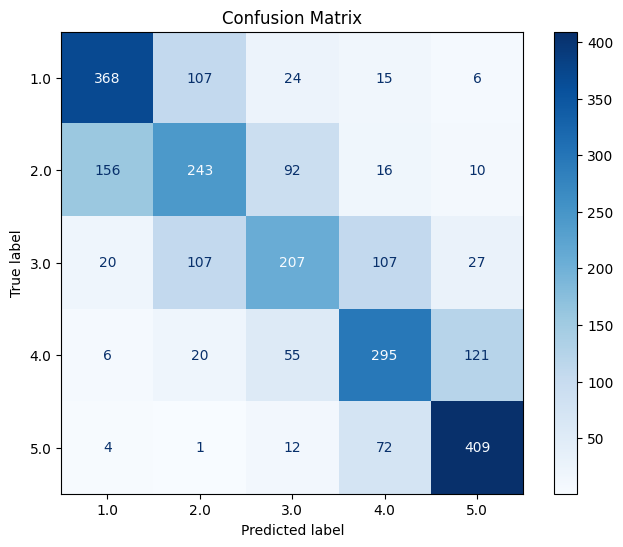

In [ ]:
predictions = trainer.predict(train_test_split["test"])
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Citation for confusion matrix: https://www.geeksforgeeks.org/how-to-plot-confusion-matrix-with-labels-in-sklearn/
cm = confusion_matrix(true_labels, predicted_labels)
fig, ax = plt.subplots(figsize=(8, 6))
label_map = {0: "1.0", 1: "2.0", 2: "3.0", 3: "4.0", 4: "5.0"} # Did something similar to this: https://stackoverflow.com/questions/53504928/using-dict-values-as-xticks-in-matplotlib
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_map[i] for i in range(len(label_map))])
cmd.plot(cmap='Blues', ax=ax)

plt.title("Confusion Matrix")
plt.show()

In [ ]:
import pickle

file_path = '/content/drive/MyDrive/distilbert_Abigail_updated_all_files.pkl'

with open(file_path, 'wb') as f:
    pickle.dump({
        'evaluation': evaluation,
        'predicted_labels': predicted_labels,
        'actual_labels': true_labels
        }, f)